In [6]:
%matplotlib inline
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [7]:
from dateutil.parser import parse
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [40]:
df = pd.read_csv('overall.csv')
df

,time,google.accounts:num_users,google.accounts:num_disabled_accounts,google.accounts:num_suspended_users
0,2015-03-23T00:00:00.000-0400,63991,34125,34123
1,2015-03-24T00:00:00.000-0400,64051,34126,34125
2,2015-03-25T00:00:00.000-0400,64115,34112,34112
3,2015-03-26T00:00:00.000-0400,64155,34110,34110
4,2015-03-27T00:00:00.000-0400,64177,34126,34124
...,...,...,...,...
1584,2019-08-13T00:00:00.000-0400,109322,76603,76602
1585,2019-08-14T00:00:00.000-0400,109409,76598,76597
1586,2019-08-15T00:00:00.000-0400,109441,76622,76621
1587,2019-08-16T00:00:00.000-0400,109464,76622,76621


In [41]:

def time_set(df):
    import datetime as dt
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]],utc = True)
    df[df.columns[0]]= df.time.dt.date
    df.set_index(df.columns[0], inplace=True)
    return df


In [42]:
def plot(df,df0):
    df1 = df.copy()
    df2 = df0.copy()
    df1 = time_set(df1)
    df2 = time_set(df2)
    for x in range(len(df1.columns)):
        plt.figure(figsize=(22, 10))
        plt.plot(df1.index, df1[df1.columns[x]], label=df1.columns[x])
        plt.plot(df2.index, df2[df2.columns[x]], label='Prophet', color='r')
        plt.legend(loc='best', fontsize='xx-large')
        plt.show()

In [43]:
def timeprediction123(df,csvfilename):
    p = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='100 days', horizon = '100 days')
    
    df_p = performance_metrics(df_cv)
    print("Performance head for " + csvfilename)
    print(df_p.head())
    print("Performance tail for " + csvfilename)
    print(df_p.tail())

    
    #df1.to_csv(data_path_write + csvfilename)
    df2 = time_pred[['yhat']]
    p.plot(time_pred)
    return df1,df2,time_pred

In [44]:
def timepredictionMAPE(df,csvfilename):
    p = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='100 days', horizon = '100 days')
    try:
        print("MAPE for " + csvfilename + " predictions")
        fig = plot_cross_validation_metric(df_cv, metric='mape')
    except:
        print("MAPE way too low to be graphed, prediction is very good")
    df2 = time_pred[['yhat']]
    return df1,df2,time_pred

In [45]:
def send_prediction(df):
    df_with_all_preds = timeprediction123(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : df.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timeprediction123(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

In [46]:
def send_predictionMAPE(df):
    df_with_all_preds = timepredictionMAPE(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : df.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timepredictionMAPE(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for google.accounts:num_users
  horizon            mse        rmse         mae      mape  coverage
0 11 days  226227.907099  475.634216  298.652732  0.003444  0.632768
1 12 days  289471.872376  538.025903  341.468024  0.003935  0.612288
2 13 days  348482.980977  590.324471  376.036354  0.004328  0.601695
3 14 days  437086.087087  661.124865  425.069419  0.004886  0.581921
4 15 days  516935.309107  718.982134  466.074244  0.005325  0.583333
Performance tail for google.accounts:num_users
    horizon           mse         rmse          mae      mape  coverage
85  96 days  4.875898e+07  6982.763360  3718.648405  0.041936  0.833333
86  97 days  4.999526e+07  7070.732813  3762.096209  0.042428  0.833333
87  98 days  5.126446e+07  7159.920098  3805.029869  0.042913  0.833333
88  99 days  5.253985e+07  7248.437875  3846.409593  0.043381  0.833333
89 100 days  5.382261e+07  7336.389300  3885.951833  0.043830  0.833333


INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00


Performance head for google.accounts:num_disabled_accounts
  horizon            mse        rmse         mae      mape  coverage
0 11 days  741862.649255  861.314489  593.166002  0.009557  0.707627
1 12 days  820754.243722  905.954880  629.602706  0.010206  0.680085
2 13 days  872864.784957  934.272329  652.432753  0.010606  0.644068
3 14 days  959668.017475  979.626468  691.386942  0.011304  0.601695
4 15 days  998184.228213  999.091702  698.330424  0.011471  0.572034
Performance tail for google.accounts:num_disabled_accounts
    horizon           mse         rmse          mae      mape  coverage
85  96 days  4.126745e+07  6423.974587  4999.394479  0.083967  0.916667
86  97 days  4.159679e+07  6449.557682  5007.708954  0.084161  0.916667
87  98 days  4.217929e+07  6494.558200  5032.079625  0.084723  0.916667
88  99 days  4.283690e+07  6544.990514  5063.113253  0.085389  0.916667
89 100 days  4.352134e+07  6597.070396  5101.101517  0.086135  0.916667


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00


Performance head for google.accounts:num_suspended_users
  horizon           mse         rmse         mae      mape  coverage
0 11 days  8.739349e+05   934.844847  621.909595  0.009974  0.707627
1 12 days  9.769573e+05   988.411489  665.234328  0.010743  0.680085
2 13 days  1.057220e+06  1028.212064  697.214434  0.011305  0.661017
3 14 days  1.174248e+06  1083.627154  746.540300  0.012187  0.635593
4 15 days  1.243138e+06  1114.961137  764.405604  0.012553  0.631356
Performance tail for google.accounts:num_suspended_users
    horizon           mse         rmse          mae      mape  coverage
85  96 days  4.613118e+07  6791.993793  5424.668932  0.090693  0.916667
86  97 days  4.660101e+07  6826.493172  5441.277505  0.091010  0.916667
87  98 days  4.732735e+07  6879.487317  5474.452466  0.091705  0.916667
88  99 days  4.813295e+07  6937.791678  5514.848796  0.092515  0.916667
89 100 days  4.894059e+07  6995.754821  5563.484881  0.093426  0.916667


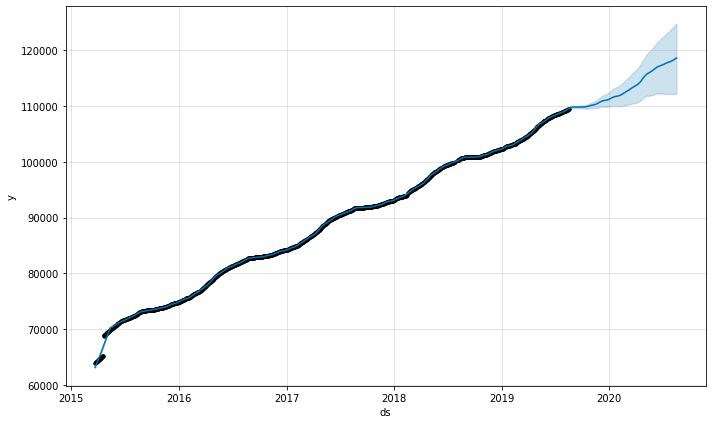

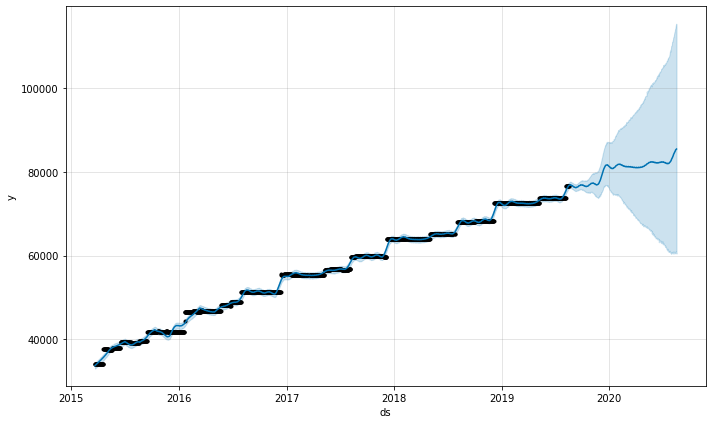

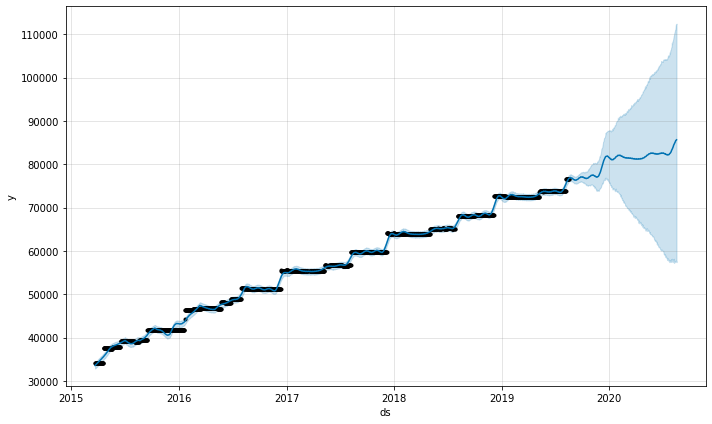

In [47]:
prediction = send_prediction(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for google.accounts:num_users predictions


INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for google.accounts:num_disabled_accounts predictions


INFO:fbprophet:Making 12 forecasts with cutoffs between 2016-05-04 00:00:00 and 2019-05-09 00:00:00


MAPE for google.accounts:num_suspended_users predictions


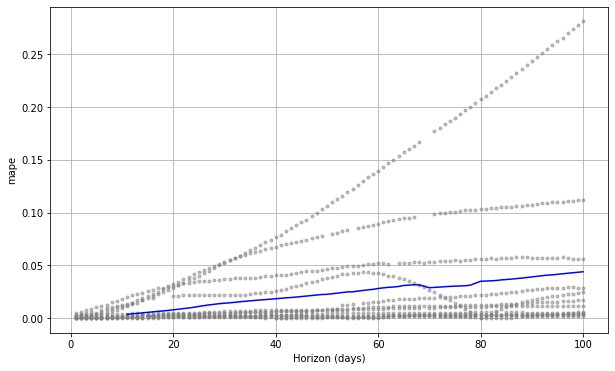

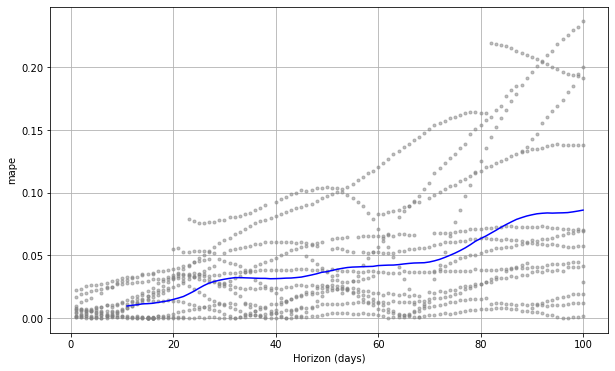

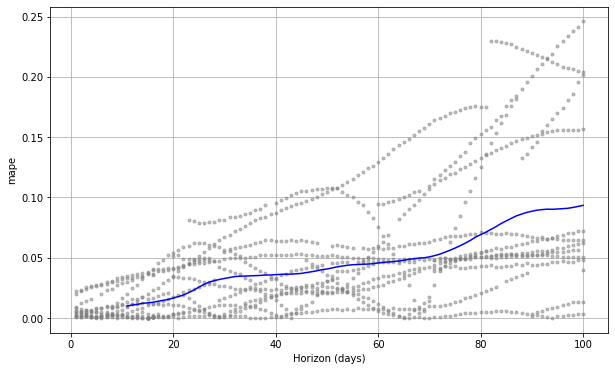

In [48]:
prediction1 = send_predictionMAPE(df)

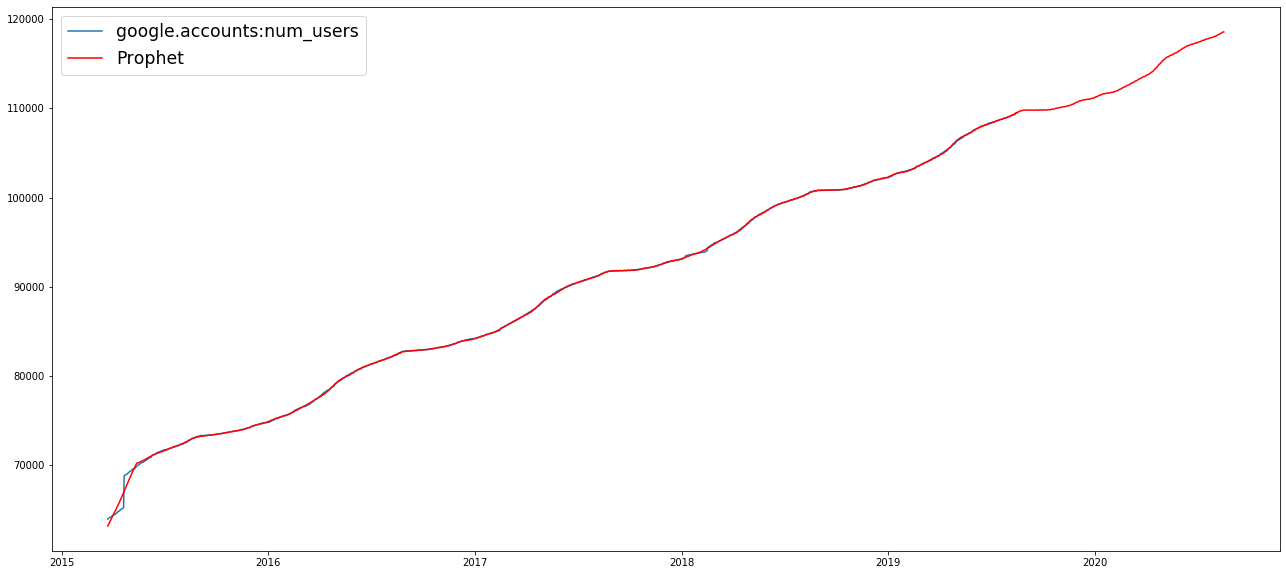

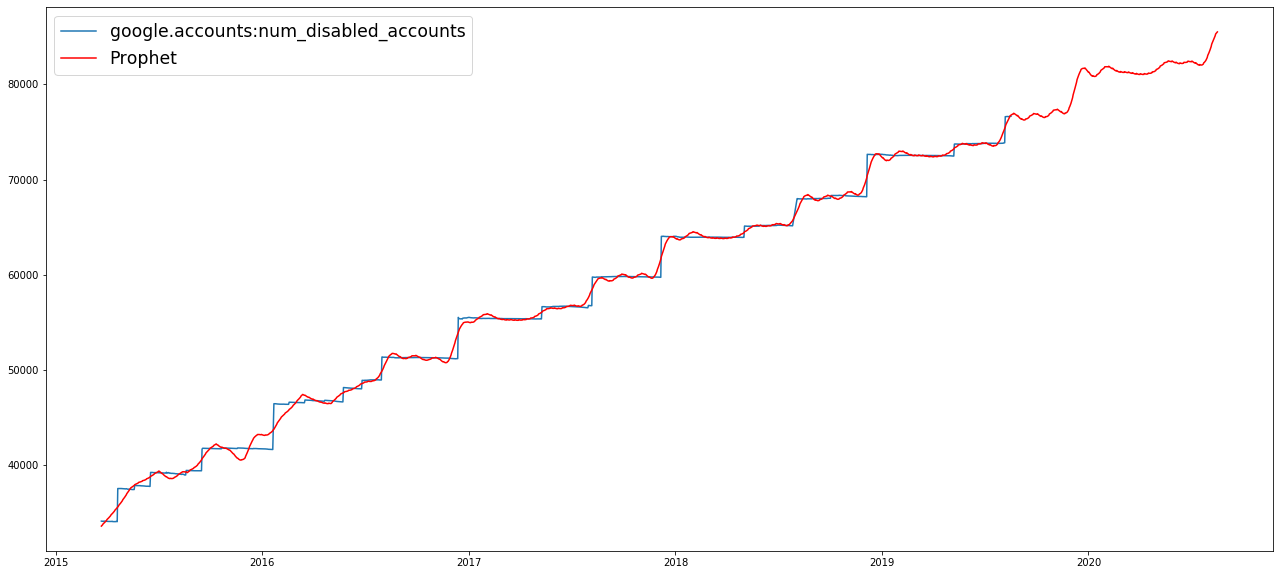

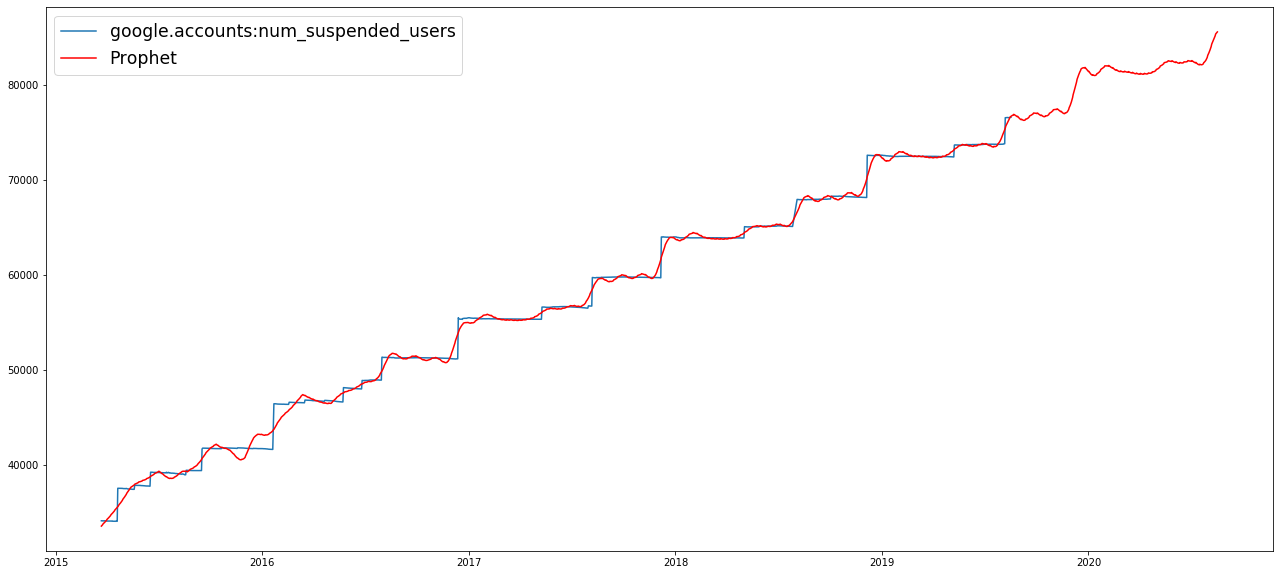

In [49]:
plot(df,prediction)